In [ ]:
import numpy as np
def Kuramoto(Theta,t,omega,N,K,mk,Aij):
    # print("Case m = 0")
    theta = 1*Theta
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
    Theta[:N] = dtheta
    return Theta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit

In [ ]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [ ]:
# @cuda.jit(nopython = True,chache=True)
@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y


@jit(nopython = True,cache=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y



# @cuda.jit#(nopython = True,chache=True)
@jit(nopython = True,cache=True)
def Kuramoto_SOL_CHIMERA(Theta,t,omega,N,Kij,alpha):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]

    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  np.sum(Kij*np.sin(theta_j - theta_i - alpha),axis=0)
    Theta[:N] = dtheta
    return Theta

In [ ]:
N1 = 128
N2 = 128
theta_init = np.random.uniform(0,np.pi,(N1+N2))

In [ ]:
N1 = 128
N2 = 128
theta_init = np.random.uniform(0,np.pi,(N1+N2)).astype(np.float32)
theta_init[:N1] = np.random.uniform(0,2*np.pi,(N1)).astype(np.float32)
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2)).astype(np.float32)
np.abs(np.mean(np.exp(theta_init*1j),axis=0))


In [ ]:
2 - 3**0.5

In [ ]:
N1 = 128 + 50
N2 = 128 
theta_init = np.random.uniform(0,2*np.pi,(N1+N2))
theta_init[:N1] = np.ones_like(np.random.uniform(0,2*np.pi,(N1)))
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2))


A = 0.31
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2

K_ij = nu*np.ones((N1+N2,N1+N2))
K_ij[:N1,:N1] = mu
K_ij[N1:,N1:] = mu



t_end = 4
dt = 0.01
r_last1 = 1
r_last2 = 1

print(rf'A = {A:.02f}, $\beta$ = {beta:.02f}')

num =0 
while min(r_last1,r_last2)>0.9:
    num +=1
    theta_init = np.random.uniform(-np.pi,np.pi,(N1+N2))
    # theta_init[:N1] = np.ones_like(np.random.uniform(-np.pi,np.pi,(N1)))
    theta_init[:N1] = np.random.uniform(-np.pi,np.pi,(N1))
    theta_init[N1:] = np.random.uniform(-np.pi,np.pi,(N2))
    
    t = np.arange(0, t_end+dt/2, dt)
    omega = 0
    alpha = np.pi/2 - beta

    sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

    rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
    rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
    np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
    r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
    r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])
    # plt.axhline(r_I_1)
    # plt.axhline(r_I_2)
    r_last1 = r_I_1[-1]
    r_last2 = r_I_2[-1]
    print(num)
    
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')

print(min(r_last1,r_last2))


In [ ]:
t_end = 50
dt = 0.01
t = np.arange(0, t_end+dt/2, dt)

sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

In [ ]:
rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])

In [ ]:
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')

print(min(r_last1,r_last2))


In [ ]:
# plt.scatter(np.arange(N1+N2),sol[-1]%(np.pi*2))
plt.scatter(np.arange(N1+N2),sol[-100]%(np.pi*2))


In [ ]:
bins = np.linspace(0,2*np.pi,30)
plt.hist((sol[-1]%(np.pi*2))[:N1],bins=bins)
plt.hist((sol[-1]%(np.pi*2))[N1:],bins=bins)
# plt.hist((sol[-1][N1:]),bins=50)#%(np.pi*2))[N1:],bins=bins)
# plt.hist(sol[-1][N1:])

In [ ]:
plt.imshow(K_ij)
plt.colorbar()


In [ ]:
# # @jit(nopython=True)
# def get_order_parameter(theta,N):
#     ''' get theta and return r and theta'''
#     rpsi = 1/N*np.sum(np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi

# # @jit(nopython=True)
# def Kuramoto_mf(Theta,t,omega,N,K):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto(Theta,t,omega,N,K,mk,Aij):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
#     Theta[:N] = dtheta
#     return Theta

# # @jit(nopython=True)
# def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta

# def get_order_parameter_ann(theta,N,mk,DEGT):
#     ''' get theta and return r and theta'''
#     rpsi = 1/(N*mk)*np.sum(DEGT*np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi



# def Kuramoto_AMF_AR(Theta,t,omega,N,K,mk,DEGT,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter_ann(theta,N,mk,DEGT)
#     dtheta = omega + K/mk*r*DEGT.flatten()*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


In [ ]:
mk = 5
N = 1000
p = mk/(N)
# G = nx.erdos_renyi_graph(N,p)
G = nx.barabasi_albert_graph(N,5)

In [ ]:
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
mk = Deg.mean()
mk

# 캡스톤

In [ ]:
A1_xg = 1.7
A2_xg = 1.4
A2_Ag = 1.4

A1_prob = A1_xg/(A1_xg+A2_xg)
A2_prob = 1 - A1_prob


In [ ]:
A1_xg -  A2_Ag

In [ ]:
A1_prob, A2_prob

In [ ]:
np.random.rand()

# Fixed point analysis

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_12809/3588213918.py:18: RuntimeWarning: divide by zero encountered in divide
  dpsi = (1+r**2)/(2*r) * (mu*r*np.sin(alpha)-nu*np.sin(psi-alpha)) - mu*np.sin(alpha)-nu*r*np.sin(psi+alpha)
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_12809/3588213918.py:40: RuntimeWarning: invalid value encountered in divide
  V = V / np.sqrt(U**2 + V**2);
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_12809/3588213918.py:55: UserWarning: The following kwargs were not used by contour: 'pivot'
  plt.contourf(R,PSI,M,pivot='mid',cmap='jet',zorder=3,levels=[-0.01,0.01])
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_12809/3588213918.py:63: RuntimeWarning: invalid value encountered in divide
  V = V / np.sqrt(U**2 + V**2);


Text(0.5, 1.0, 'A=0.35,$\\beta$=0.1')

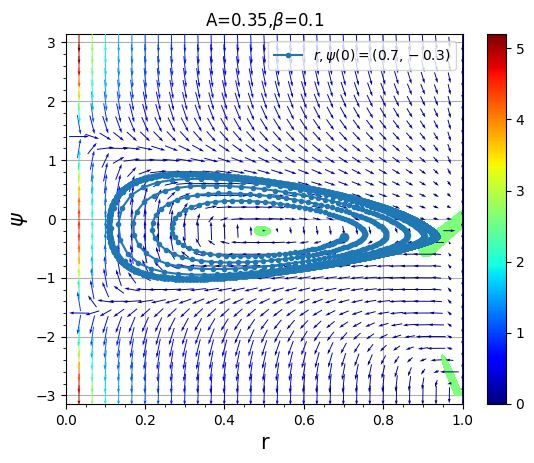

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


A = 0.2
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2


def myFun(u,t=0,A=0.1,beta=0.1):
	r,psi = u[0],u[1]
	nu = (1-A)/2
	mu = (1+A)/2
	alpha = np.pi/2 - beta
	dr = (1-r**2)/2 *(mu*r*np.cos(alpha)+nu*np.cos(psi-alpha))
	dpsi = (1+r**2)/(2*r) * (mu*r*np.sin(alpha)-nu*np.sin(psi-alpha)) - mu*np.sin(alpha)-nu*r*np.sin(psi+alpha)
	return (dr,dpsi)


A = 0.35
beta = 0.1

u0 = [0.2,-0.3]
t = np.linspace(0,4000,12000)
u0s = [[0.7,-0.3]]#,[-0.5,3],[-1,-1],[-2,-0.5]]
for u0 in u0s:
	r_,psi_ = u0
	u = odeint(myFun,u0,t,args=(A,beta))
	plt.plot(u[:,0],u[:,1],lw=1.5,label=r'$r,\psi(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5,marker='.')
	plt.scatter(u[0,0],u[0,1],zorder=5)

x = np.linspace(0,1,501)
y = np.linspace(-3,3,501)
R,PSI = np.meshgrid(x,y)
U,V = myFun([R,PSI],A=A,beta=beta)
M = (np.hypot(U,V))
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
MIN = np.argmin(M)

xs = np.linspace(-3,-1e-5,1000)



# plt.figure(dpi=400)
# plt.axhline(0,color='black')
# plt.plot(xs,-np.log(-xs),color='black')
# plt.plot(x,xdot(x,y))
# Q = plt.quiver(R*np.cos(PSI),R*np.sin(PSI),U,V,M,pivot='mid',cmap='jet',zorder=3)
# Q = plt.quiver(R,PSI,U,V,M,pivot='mid',cmap='jet',zorder=3)


plt.contourf(R,PSI,M,pivot='mid',cmap='jet',zorder=3,levels=[-0.01,0.01])

x = np.linspace(0,1,31)
y = np.linspace(-3,3,31)
R,PSI = np.meshgrid(x,y)
U,V = myFun([R,PSI],A=A,beta=beta)
M = (np.hypot(U,V))
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
Q = plt.quiver(R,PSI,U,V,M,scale=20,pivot='mid',cmap='jet',zorder=3)



plt.colorbar()
plt.xlim(0,1)
plt.ylim(-np.pi,np.pi)
# plt.ylim(-0.5,0.5)
ax =plt.gca()
ax.grid(True)
ax.minorticks_on()

plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
plt.xlabel('r',fontsize=15)
plt.ylabel(r'$\psi$',fontsize=15)
plt.legend()


psi = -2*beta -2*beta**2 - 7/3*beta**3 + 20*beta**4/3 + 181*beta**5/60
plt.title(rf'A={A},$\beta$={beta}')

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')

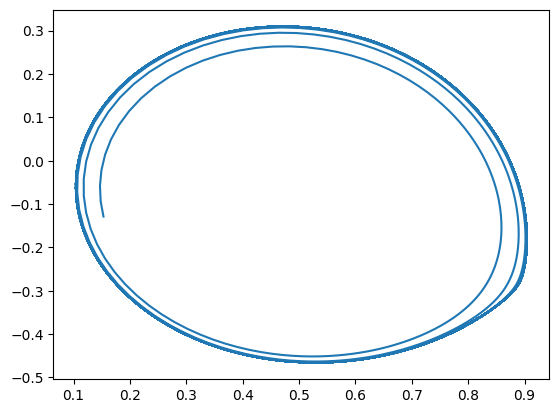

In [192]:
N1 = 128
N2 = 128 
theta_init = np.random.uniform(0,2*np.pi,(N1+N2))
theta_init[:N1] = np.zeros_like(np.random.uniform(0,2*np.pi,(N1)))
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2))


A = 0.25
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2

K_ij = nu*np.ones((N1+N2,N1+N2))
K_ij[:N1,:N1] = mu
K_ij[N1:,N1:] = mu



t_end = 4
dt = 0.01
r_last1 = 1
r_last2 = 1

In [193]:
std = 0.1
theta_init[N1:] = np.random.normal(-0.1,std,(N2))
r_ = np.abs(np.mean(np.exp(theta_init[N1:]*1j)))
r_

0.9944209370260867

In [194]:
from scipy.stats import norm
from scipy.interpolate import interp1d


In [195]:
stds = np.linspace(1e-3,3,100)
rs = []
for std in stds:
    # theta_init[N1:] = scipy.normal(-0.1,std,(N2))
    x_ = np.linspace(0,1,1000)[1:-1]
    y_ = norm.ppf(x_,loc=-0.1,scale=std)
    # theta_init[N1:] = norm.pdf(x_,-0.1,std)
    r_ = np.abs(np.mean(np.exp(y_*1j)))
    rs.append(r_)
r_to_stds = interp1d(rs,stds)

Text(0.5, 0, 'std')

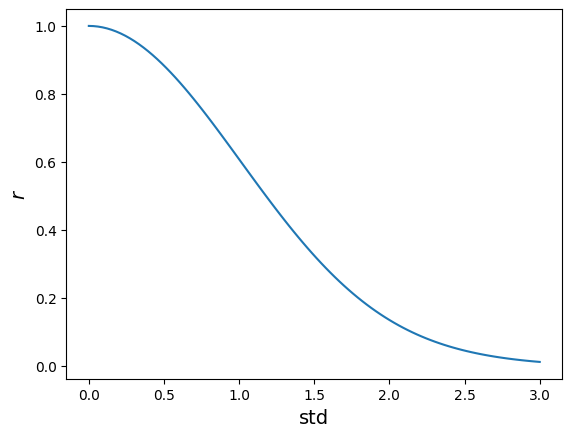

In [196]:
plt.plot(stds,rs)
plt.ylabel(r'$r$',fontsize=14)
plt.xlabel('std',fontsize=14)

In [325]:
# r = 0.1
std_r = r_to_stds(r_)
std_r,r_,psi_

(array(0.84743954), 0.7, -0.3)

A = 0.35, $\beta$ = 0.10
1.0


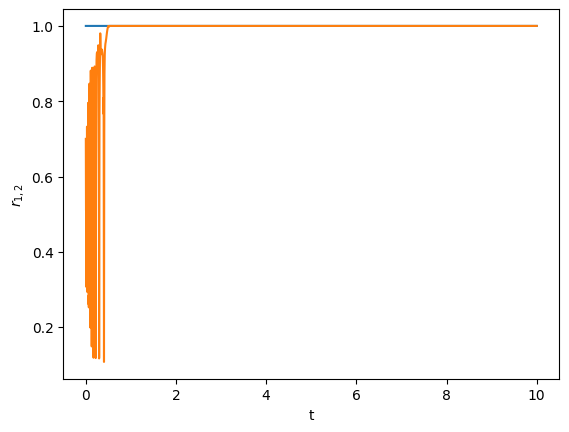

In [339]:
std_r = r_to_stds(r_)

N1 = 1024
N2 = 1024
theta_init = np.random.uniform(0,2*np.pi,(N1+N2))
theta_init[:N1] = np.zeros_like(np.random.uniform(0,2*np.pi,(N1)))
# theta_init[N1:] = np.random.normal(-0.1,std_r,N2)
theta_init[N1:] =  norm.ppf(np.linspace(0,1,N2+2)[1:-1],-psi_,std_r)


A = 0.350
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2

K_ij = nu*np.ones((N1+N2,N1+N2))
K_ij[:N1,:N1] = mu
K_ij[N1:,N1:] = mu



t_end = 10
dt = 1e-3
r_last1 = 1
r_last2 = 1

print(rf'A = {A:.02f}, $\beta$ = {beta:.02f}')

num =0  # 참조 테스트
# while min(r_last1,r_last2)>0.9:
#     num +=1
    # theta_init = np.random.uniform(-np.pi,np.pi,(N1+N2))
    # theta_init[:N1] = np.ones_like(np.random.uniform(-np.pi,np.pi,(N1)))
    # theta_init[:N1] = np.random.uniform(-np.pi,np.pi,(N1))
    # theta_init[N1:] = np.random.uniform(-np.pi,np.pi,(N2))
    
t = np.arange(0, t_end+dt/2, dt)
omega = 0
alpha = np.pi/2 - beta

sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])
# plt.axhline(r_I_1)
# plt.axhline(r_I_2)
r_last1 = r_I_1[-1]
r_last2 = r_I_2[-1]
# print(num)
    
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')
plt.xlim()
print(min(r_last1,r_last2))



1.0


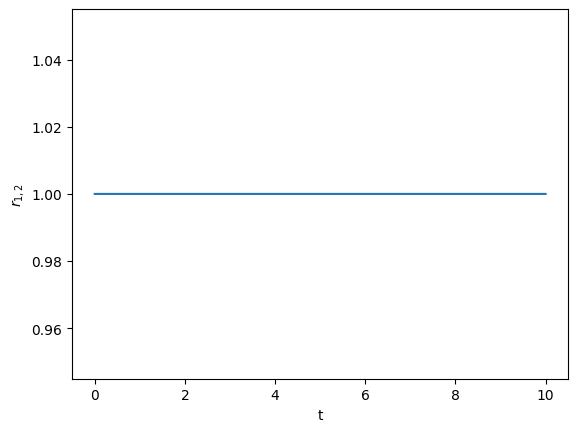

In [344]:
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')
# plt.xlim(90,100)
print(min(r_last1,r_last2))

In [ ]:
norm.ppf(x_,loc=-0.1,scale=std)

In [ ]:
plt.hist(theta_init[:N1])
plt.hist(theta_init[N1:])

In [ ]:
theta_init = np.zeros((N1+N2))


In [ ]:
AnsP 

In [77]:
import numpy as np
from scipy.special import erf
erf(3)

0.9999779095030014

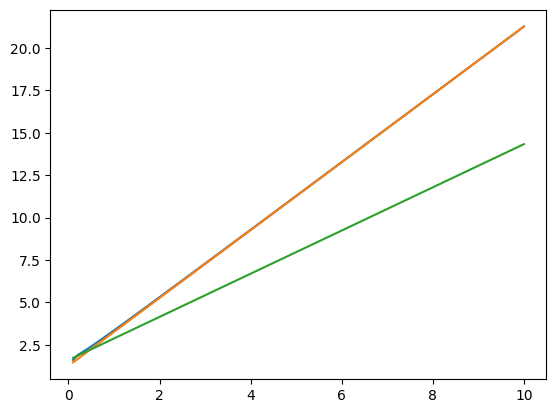

In [99]:
import numpy as np
from scipy.special import erf
def get_Kc(mu,sigma=1):
    A = 1/(2**0.5*mu*sigma)
    K_c = (8**0.5/np.pi**0.5) * sigma /(1- (np.exp(A**2))*(1-erf(A)))
    return K_c

def get_Kc_low_m(mu,sigma=1):
    K_c = 8**0.5/np.pi**0.5 * sigma + 4/np.pi* sigma**2*mu
    return K_c


def get_Kc_large_m(mu,sigma=1):
    K_c = 2 * sigma**2*mu + np.sqrt(np.pi/2) *sigma
    return K_c
# K_c = 2*2**0.5/np.pi *
import matplotlib.pyplot as plt

ms = np.linspace(0,10,100)[1:]
plt.plot(ms,get_Kc(ms))
plt.plot(ms,get_Kc_large_m(ms))
plt.plot(ms,get_Kc_low_m(ms))
# plt.ylim(0,10)



In [98]:
get_Kc(5)

11.275895964718277

In [92]:
erf(3)

0.9999779095030014

In [100]:
import numpy as np
import matplotlib.pyplot as plt

In [119]:
A = np.sum(np.random.rand(5400) < 0.0430/100)
B = np.sum(np.random.rand(5400) < 0.0460/100)
# np.sum(np.random.rand(5400) < 0.0430/100)

In [120]:
print(A,B)

0 5


In [ ]:
# correlation, 

In [122]:
np.log(1700)

7.438383530044307

In [123]:
import numpy as np

In [162]:
A = np.linspace(0,180,int(1e+5)+1)
eps = 1e-5
condition = ~((A>90-eps)&(A<90+eps))
B = np.where(condition, A,np.nan)
# A = np.linspace(0,180,int(1e+1)+1)
# A = A[np.where(~((A>89)&(A<91)))]

In [178]:
A = np.linspace(0,180,int(1e+5)+1)
eps = 1e+0
condition = ~((A>90-eps)&(A<90+eps))
B = np.where(condition, A,np.nan)

def func(theta):
    UP = 2*np.cos(theta)**2
    DOWN = np.pi- 2*theta - np.sin(2*theta)
    return UP/DOWN

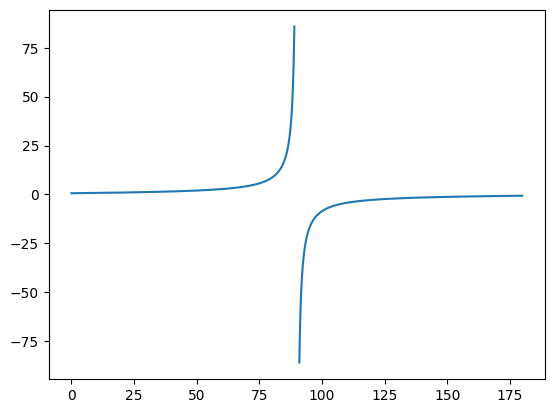

In [179]:
plt.plot(B,func(np.deg2rad(B)))
# plt.ylim(-10,10)

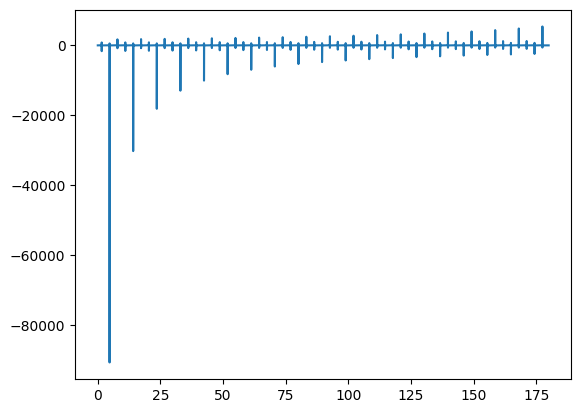

In [167]:
plt.plot(A,np.tan(A))

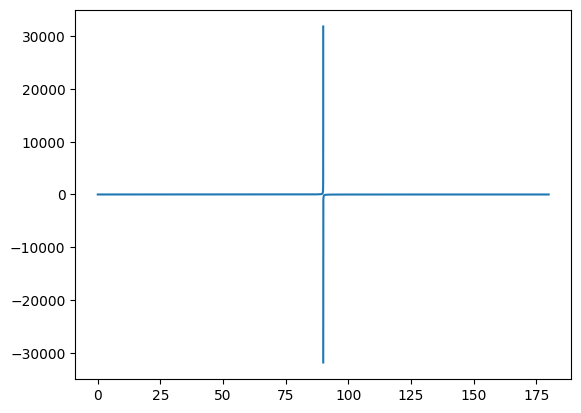

In [166]:
plt.plot(B, 1/np.cos(np.deg2rad(B)))

In [148]:
A_arg = np.where(~((A>89)&(A<91)))

In [152]:
A

array([  0.,  18.,  36.,  54.,  72., 108., 126., 144., 162., 180.])